# Mean/Covariance of a data set and effect of a linear transformation

We are going to investigate how the mean and (co)variance of a dataset changes
when we apply affine transformation to the dataset.

## Learning objectives

1. Get Farmiliar with basic programming using Python and Numpy/Scipy.
2. Learn to appreciate implementing
   functions to compute statistics of dataset in vectorized way.
3. Understand the effects of affine transformations on a dataset.
4. Understand the importance of testing in programming for machine learning.

First, let's import the packages that we will use for the week

In [3]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_lfw_people, fetch_olivetti_faces

from ipywidgets import interact, interactive

Next, we are going to retrieve Olivetti faces dataset.

When working with some datasets, before digging into further analysis, it is almost always
useful to do a few things to understand your dataset. First of all, answer the following
set of questions:

1. What is the size of your dataset?
2. What is the dimensionality of your data?

The dataset we have are usually stored as 2D matrices, then it would be really important
to know which dimension represents the dimension of the dataset, and which represents
the data points in the dataset. 

__When you implement the functions for your assignment, make sure you read
the docstring for what each dimension of your inputs represents the data points, and which 
represents the dimensions of the dataset!__. For this assignment, our data is organized as
__(D,N)__, where D is the dimensionality of the samples and N is the number of samples.

In [4]:
image_shape = (64, 64)
# Load faces data
dataset = fetch_olivetti_faces(data_home='./')
faces = dataset.data.T

print('Shape of the faces dataset: {}'.format(faces.shape))
print('{} data points'.format(faces.shape[1]))

Shape of the faces dataset: (4096, 400)
400 data points


When your dataset are images, it's a really good idea to see what they look like.

One very convenient tool in Jupyter is the `interact` widget, which we use to visualize the images (faces). For more information on how to use interact, have a look at the documentation [here](http://ipywidgets.readthedocs.io/en/stable/examples/Using%20Interact.html).

We have created two functions which help you visualize the faces dataset. You do not need to modify them.

In [5]:
def show_face(face):
    plt.figure()
    plt.imshow(face.reshape((64, 64)), cmap='gray')
    plt.show()

In [6]:
def display_faces(n=0):
    plt.imshow(faces[:, n].reshape((64, 64)), cmap='gray', aspect='equal')


interactive_plot = interactive(display_faces, n=(0, faces.shape[1] - 1))
output = interactive_plot.children[-1]
output.layout.height = '300px'
interactive_plot

interactive(children=(IntSlider(value=0, description='n', max=399), Output(layout=Layout(height='300px'))), _d…

## 1. Mean and Covariance of a Dataset

In this week, you will need to implement functions in the cell below which compute the mean and covariance of a dataset.

You will implement both mean and covariance in two different ways. First, we will implement them using Python's for loops to iterate over the entire dataset. Later, you will learn to take advantage of Numpy and use its library routines. In the end, we will compare the speed differences between the different approaches.

In [7]:
# GRADED FUNCTION: DO NOT EDIT THIS LINE

def mean_naive(X):
    "Compute the mean for a dataset X by iterating over the data points"
    # X is of size (D, N) where D is the dimensionality and N the number of data points
    D, N = X.shape
    mean = np.zeros((D, 1))
    for n in range(N):
        mean[:, 0] = mean[:, 0] + X[:, n]
    mean = mean / N
    return mean

def cov_naive(X):
    """Compute the covariance for a dataset of size (D, N) 
    where D is the dimension and N is the number of data points"""
    D, N = X.shape
    covariance = np.zeros((D, D))
    mu = mean_naive(X)
    X_centered = X - mu
    for n in range(N):
        covariance = covariance + X_centered[:, n].reshape((D, 1)) @ X_centered[:, n].reshape((D, 1)).T
    covariance = covariance / N
    return covariance


def mean(X):
    "Compute the mean for a dataset of size (D, N) where D is the dimension and N is the number of data points"
    D, N = X.shape
    return np.mean(X, axis=1, keepdims=True)


def cov(X):
    "Compute the covariance for a dataset"
    # X is of size (D,N)
    D, N = X.shape
    X_centered = X - mean(X)
    covariance_matrix = X_centered @ X_centered.T / N
    return covariance_matrix


Now, let's see whether our implementations are consistent

In [8]:
# Let's first test the functions on some hand-crafted dataset.

X_test = np.arange(6).reshape(2,3)
expected_test_mean = np.array([1., 4.]).reshape(-1, 1)
expected_test_cov = np.array([[2/3., 2/3.], [2/3.,2/3.]])
print('X:\n', X_test)
print('Expected mean:\n', expected_test_mean)
print('Expected covariance:\n', expected_test_cov)

np.testing.assert_almost_equal(mean(X_test), expected_test_mean)
np.testing.assert_almost_equal(mean_naive(X_test), expected_test_mean)

np.testing.assert_almost_equal(cov(X_test), expected_test_cov)
np.testing.assert_almost_equal(cov_naive(X_test), expected_test_cov)

X:
 [[0 1 2]
 [3 4 5]]
Expected mean:
 [[1.]
 [4.]]
Expected covariance:
 [[0.66666667 0.66666667]
 [0.66666667 0.66666667]]


We now test that both implementation should give identical results running on the faces dataset.

In [10]:
np.allclose(mean(faces), mean_naive(faces))
np.allclose(cov(faces), cov_naive(faces))

True

With the `mean` function implemented, let's take a look at the _mean_ face of our dataset!

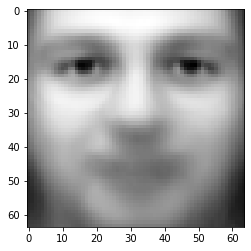

In [11]:
def mean_face(faces):
    return faces.mean(axis=1).reshape((64, 64))

plt.imshow(mean_face(faces), cmap='gray');

Loops in Python are slow, and most of the time you want to utilise the fast native code provided by Numpy without explicitly using
for loops. To put things into perspective, we can benchmark the two different implementation with the `%time` function
in the following way:

In [12]:
# We have some HUGE data matrix which we want to compute its mean
X = np.random.randn(20, 1000)

# Benchmarking time for computing mean
%time m1 = mean_naive(X)
%time m2 = mean(X)

np.allclose(m1, m2)


Wall time: 1.99 ms
Wall time: 0 ns


True

In [15]:
# Benchmarking time for computing covariance
%time a = cov_naive(X)
%time a = cov(X)



Wall time: 5.98 ms
Wall time: 0 ns


As you can see, using Numpy's functions makes the code much faster! Therefore, whenever you can use something that's implemented in Numpy, be sure that you take advantage of that.

## 2. Affine Transformation of Datasets
In this week we are also going to verify a few properties about the mean and
covariance of affine transformation of random variables.

Consider a data matrix $\boldsymbol X$ of size $(D, N)$. We would like to know
what is the covariance when we apply affine transformation $\boldsymbol A\boldsymbol x_i + \boldsymbol b$ for each datapoint $\boldsymbol x_i$ in $\boldsymbol X$, i.e.,
we would like to know what happens to the mean and covariance for the new dataset if we apply affine transformation.

For this assignment, you will need to implement the `affine_mean` and `affine_covariance` in the cell below.

In [16]:
def affine_mean(mean, A, b):
    """Compute the mean after affine transformation
    Args:
        x: ndarray, the mean vector
        A, b: affine transformation applied to x
    Returns:
        mean vector after affine transformation
    """
    return A @ mean + b


def affine_covariance(S, A, b):
    """Compute the covariance matrix after affine transformation
    Args:
        S: ndarray, the covariance matrix
        A, b: affine transformation applied to each element in X        
    Returns:
        covariance matrix after the transformation
    """
    return A @ S @ A.T

Once the two functions above are implemented, we can verify the correctness our implementation. Assuming that we have some $\boldsymbol A$ and $\boldsymbol b$.

In [17]:
random = np.random.RandomState(42)
A = random.randn(4, 4)
b = random.randn(4, 1)

Next we can generate some random matrix $\boldsymbol X$.

In [18]:
X = random.randn(4, 100) # D = 4, N = 100

Assuming that for some dataset $\boldsymbol X$, the mean and covariance are $\boldsymbol m$, $\boldsymbol S$, and for the new dataset after affine transformation $\boldsymbol X'$, the mean and covariance are $\boldsymbol m'$ and $\boldsymbol S'$, then we would have the following identity:

$$\boldsymbol m' = \text{affine_mean}(\boldsymbol m, \boldsymbol A, \boldsymbol b)$$

$$\boldsymbol S' = \text{affine_covariance}(\boldsymbol S, \boldsymbol A, \boldsymbol b)$$

In [19]:
X1 = (A @ X) + b  # applying affine transformation to each sample in X
X2 = (A @ X1) + b # twice

In [20]:
np.allclose(mean(X1), affine_mean(mean(X), A, b))
np.allclose(cov(X1),  affine_covariance(cov(X), A, b))

True

In [21]:
np.allclose(mean(X2), affine_mean(mean(X1), A, b))
np.allclose(cov(X2),  affine_covariance(cov(X1), A, b))

True